# Analysis of NIH data using pandas

The purpose of this project is to demonstrate basic data analysis skills with pandas using a funding dataset from the National Institutes of Health. The following skills are demonstrated in this project:

-Dataframe filtering based on certain criteria

-Dataframe parsing into smaller datasets

-Dataset merging

-String management with regular expressions

-Dataset analysis for specific insights (e.g. institutes awarding the most funding, Principal Investigators with the most grants, etc)

-Data visualization

-Statistical analysis

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [2]:
pd.set_option('display.max_columns', None)

# Dataframe Filtering and Parsing

In [3]:
#load data; display first 5 rows
data = pd.read_excel('nih-Worldwide2015.xls', 'Sheet1')

In [4]:
#show data types for each column
data.dtypes

Organization Name                       object
Project Number                          object
Funding Mechanism                       object
NIH Reference                            int64
PI Name                                 object
Project Title                           object
DEPT NAME                               object
NIH Dept Combining Name                 object
NIH MC Combining Name                   object
Direct Cost                            float64
Indirect Cost                          float64
Funding                                  int64
Congressional District                 float64
City                                    object
State or Country Name                   object
Zip Code                                object
Attributed to Medical School            object
Medical School Location                 object
Institution Type                        object
Award Notice Date               datetime64[ns]
FOA                                     object
dtype: object

In [5]:
#filter data for projects attributed to a medical school
med_school = data[data['Attributed to Medical School'] == 'Y']

In [6]:
#parse data in Project Number column into two separate strings and save as new columns: code (the activity code) and icode (the institution code)
data['code'] = data['Project Number'].str[1:4] #2nd, 3rd, and 4th characters
data['icode'] = data['Project Number'].str[4:6] #5th and 6th characters


In [7]:
#use regular expression to filter for only rows where the activity code starts with a letter
data2 = data[data['code'].str.match(r'^[A-Za-z]')]

# Simple Dataset Analysis

In [8]:
#identify NIH institutes that gave the most funding

#group by 'icode' column, isolate funding column, sum the funding for each group, and display the 10 largest
top_funders = data2.groupby('icode')['Funding'].sum().nlargest(10)
top_funders

icode
CA    3067378774
AI    2816658845
GM    2305153448
HL    2275682842
DK    1594835858
NS    1339911506
MH    1161677004
AG     999538398
HD     971449006
DA     832033498
Name: Funding, dtype: int64

In [9]:
#identify Principal Investigators with the most grants
top_PIs = data2['PI Name'].value_counts().head(10)
top_PIs

PI Name
WOODLAND, DAVID L.       42
STEWART, DAVID J.        30
KAPLAN, DAVID L          12
CALIGIURI, MICHAEL A.    10
WANG, TIMOTHY CRAGIN     10
SHARPLESS, NORMAN E      10
SNYDER, MICHAEL P         9
REZNIKOFF, WILLIAM S.     9
ADAMSON, PETER C.         9
BRADY, KATHLEEN T.        9
Name: count, dtype: int64

In [10]:
#identify top 10 organizations with the most diverse funding using the activity code column as the funding type

#group by 'Organization Name', isolate the 'code' column, count the number of unique codes, sort in descending order, and then display the top 10
top_orgs = data2.groupby('Organization Name')['code'].nunique().sort_values(ascending = False).head(10)
top_orgs

Organization Name
UNIVERSITY OF WASHINGTON                  58
EMORY UNIVERSITY                          54
WASHINGTON UNIVERSITY                     53
UNIVERSITY OF CALIFORNIA LOS ANGELES      53
UNIVERSITY OF MICHIGAN                    53
UNIVERSITY OF PITTSBURGH AT PITTSBURGH    53
UNIV OF NORTH CAROLINA CHAPEL HILL        52
UNIVERSITY OF PENNSYLVANIA                52
JOHNS HOPKINS UNIVERSITY                  52
DUKE UNIVERSITY                           52
Name: code, dtype: int64

In [11]:
#Calculate total and average funding for each state or country

#group by the 'State or Country Name', isolate the 'Funding' column, and use agg function to calculate the sum and mean of the funding column for each group
funding_data = data2.groupby('State or Country Name')['Funding'].agg(Total_State_Funding = 'sum', Average_State_Funding = 'mean').reset_index()
funding_data

,State or Country Name,Total_State_Funding,Average_State_Funding
0,ALABAMA,258212374,456205.607774
1,ALASKA,13530884,751715.777778
2,ARGENTINA,832633,118947.571429
3,ARIZONA,150372947,382628.363868
4,ARKANSAS,40322657,443106.120879
...,...,...,...
93,WEST VIRGINIA,20974749,355504.220339
94,WISCONSIN,400636646,442692.426519
95,WYOMING,10459943,615290.764706
96,ZAMBIA,1760769,880384.500000


# Combine Datasets

In [12]:
#filter dataframe to include only US states
#import additional dataset to add column with state acronyms

#import additional dataset
US_data = pd.read_csv('us-states.csv',header = None)

#since the full state name column in 'us-states.csv' has ',US' afer each state, split the string on the comma and select the first half (state name)
US_data[0] = US_data[0].str.upper()
US_data[0] = US_data[0].str.split(',').str[0]

#rename columns so that we can join with the other dataset on the 'State of Country Name' column
US_data.columns = ['State or Country Name','State_Acronym']

#perform inner join to combine datasets and isolate rows with US funding
States_data = pd.merge(data2,US_data, on='State or Country Name', how='inner')

# Visualize Data

In [13]:
#merge state data with funding data to determine total funding for each state
States_data = States_data.merge(funding_data, on = 'State or Country Name', how = 'left')
States_data = States_data.sort_values('State_Acronym')

<Axes: xlabel='State_Acronym', ylabel='Total_State_Funding'>

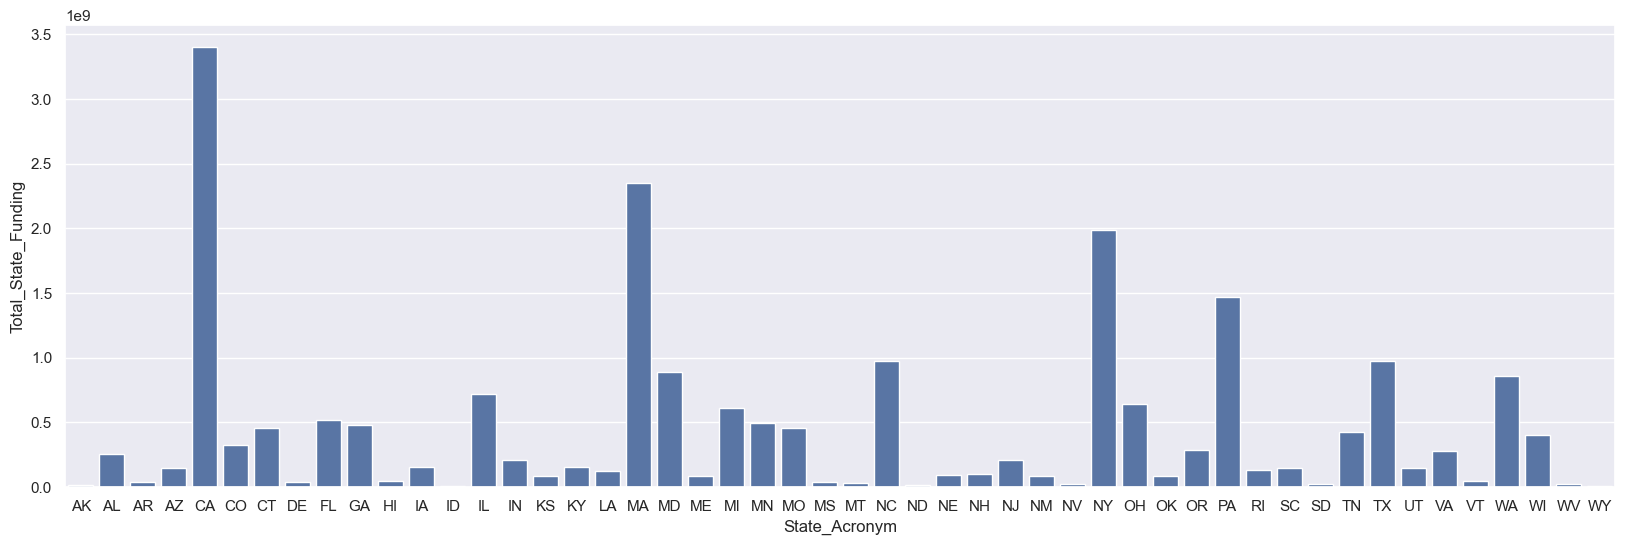

In [14]:
#barplot of total funding for each state
sns.set(rc={'figure.figsize': (20, 6)})
sns.barplot(data=States_data, x='State_Acronym',y='Total_State_Funding')

# Statistical Analysis
Investigate the relationship between amount of funding for each project and number of papers published

In [15]:
#load additional dataset containing published papers for each project number 
papers = pd.read_csv('papers.csv')

#merge with original dataset to acquire the funding for each project number
papers = pd.merge(papers, data[['Project Number','Funding']], on = 'Project Number', how = 'left')

<Axes: xlabel='Funding', ylabel='papersNum'>

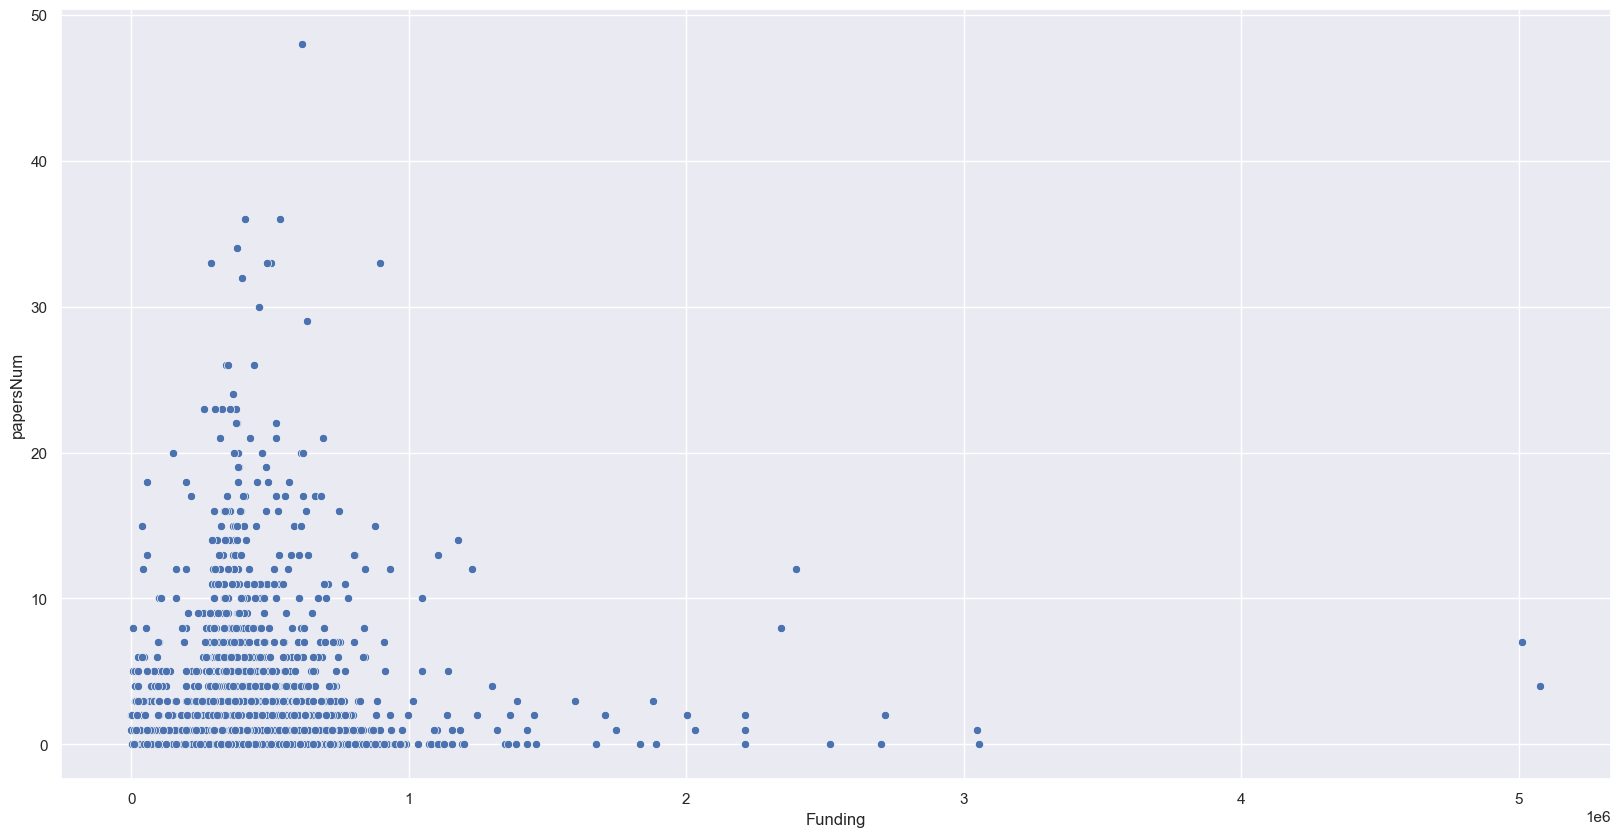

In [16]:
#scatter plot of funding amount and number of papers
sns.set(rc={'figure.figsize': (20,10)})
sns.scatterplot(data=papers,x='Funding',y='papersNum')

In [17]:
#Evaluate relationship between funding amount and number of papers published with a linear regression model
stats_data = papers[['year','Funding','papersNum']]
stats_data = sm.add_constant(stats_data)
lsmod = sm.OLS(stats_data['papersNum'], stats_data[['const','year','Funding']]).fit()
lsmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              papersNum   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     16.45
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           7.54e-08
Time:                        19:18:22   Log-Likelihood:                -13145.
No. Observations:                5000   AIC:                         2.630e+04
Df Residuals:                    4997   BIC:                         2.631e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0150      0.109      9.303      0.000       0.801       1.229
year           0.0357      0.007      5.034      0.000       0.022       0.050
Funding     5.728e-07   2.14e-07      2.675      0.007    1.53e-07    9.93e-07
==============================================================================
Omnibus:                     4918.989   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           255684.936
Skew:                           4.828   Prob(JB):                         0.00
Kurtosis:                      36.676   Cond. No.                     1.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given that the p-value is less than 0.05, this model suggests that there is a statistically significant relationship between the amount of funding a project receives and the number of papers published associated with that project. 